In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, JLD2, OrdinaryDiffEq
using Plots;

In [3]:
JLD2.@load("Ocean_geostrophic_velocity.jld2");
UV = interpolateVF(Lon, Lat, Time, UT, VT);

In [4]:
# Parameters
grid_resolution        = 10
quadrature_order       = 5
nevs                   = 6
ϵ                      = 0.01
num_steps              = 10
t_initial              = minimum(Time)
t_end                  = t_initial+70     # parameter value corresponding to ϵ=0 (t_max is 90)
wind_scale             = 1e-5
wind_center            = 30;
solver_tolerance       = 1e-8
solver                 = OrdinaryDiffEq.BS5();

In [5]:
lattitude_range = range(minimum(Lat),maximum(Lat),length=size(UT)[2]) # should be equal to Lat, but just to be safe
wind_u = repeat(collect(wind_scale.*(lattitude_range.-wind_center))',size(UT)[1],1,size(UT)[3])
wind_v = zero(VT); #no northward component of wind
wind = interpolateVF(Lon, Lat, Time, wind_u, wind_v);

In [6]:
# it would be much easier to write this with interp_rhs and p=UV .+ param.*wind, but that has the wrong type
interp_rhs_scaled = OrdinaryDiffEq.ODEFunction{false}((u,p,t) -> p[1](u[1],u[2],t) .+ p[3].*p[2](u[1],u[2],t))
function T(x,param)
    flow(interp_rhs_scaled, x, [t_initial, t_end]; 
        p=(UV, wind, param), tolerance=solver_tolerance, solver=solver)[end]
end

T (generic function with 1 method)

In [7]:
LL, UR = (-4.0, -34.0), (6.0, -28.0)
lon_resolution = grid_resolution
lat_resolution = Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*grid_resolution))
ctx, _ = regularTriangularGrid((lon_resolution, lat_resolution), 
        LL, UR, quadrature_order = quadrature_order);
bdata = getHomDBCS(ctx, "all");

In [8]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [9]:
# assemble K
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀, bdata=bdata)
nothing

660.198376 seconds (228.53 M allocations: 13.429 GiB, 0.39% gc time)


In [10]:
evs = zeros(num_steps+1,nevs,)
evs[Int(num_steps/2 +1),:] , _ = eigs(K, M, nev=nevs, which=:SM);

In [ ]:
efs = zeros(num_steps+1,nevs)

In [ ]:
if diff_method == "autodiff"
    Adot = x -> linear_response_tensor(T, x, 0)
elseif diff_method == "exact"
    Adot = x -> linear_response_tensor(T₀,dotT₀, x, 0)
end
@time L = assembleStiffnessMatrix(ctx, Adot);

In [11]:
for i in 1:(num_steps/2)
    DTϵ(x) = linearized_flow_autodiff(y -> T(y,i*ϵ) , x)
    Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
    @time Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata)
    DTminusϵ(x) = linearized_flow_autodiff(y -> T(y,-i*ϵ) , x)
    Aminusϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTminusϵ(x))))
    @time Kminusϵ = assembleStiffnessMatrix(ctx, Aminusϵ, bdata=bdata)
    evs[Int(num_steps/2 +1+i),:], _ = eigs(Kϵ, M, nev=nevs, which=:SM)
    evs[Int(num_steps/2 +1-i),:], _ = eigs(Kminusϵ, M, nev=nevs, which=:SM)
    print(Int(i), "/" ,Int(num_steps/2), "\n")
end
nothing

654.440183 seconds (196.43 M allocations: 11.336 GiB, 0.24% gc time)
638.606110 seconds (196.23 M allocations: 11.325 GiB, 0.19% gc time)
1/50
652.420741 seconds (182.33 M allocations: 10.723 GiB, 0.17% gc time)
635.565656 seconds (182.33 M allocations: 10.723 GiB, 0.17% gc time)
2/50
651.935328 seconds (182.33 M allocations: 10.723 GiB, 0.22% gc time)
636.577279 seconds (182.33 M allocations: 10.723 GiB, 0.18% gc time)
3/50
650.896755 seconds (182.33 M allocations: 10.723 GiB, 0.17% gc time)
637.823372 seconds (182.33 M allocations: 10.723 GiB, 0.17% gc time)
4/50
650.521505 seconds (182.33 M allocations: 10.723 GiB, 0.17% gc time)
638.372531 seconds (182.33 M allocations: 10.723 GiB, 0.17% gc time)
5/50
651.074096 seconds (182.33 M allocations: 10.723 GiB, 0.23% gc time)
638.408005 seconds (182.33 M allocations: 10.723 GiB, 0.17% gc time)
6/50
652.017414 seconds (182.33 M allocations: 10.723 GiB, 0.17% gc time)
640.311870 seconds (182.33 M allocations: 10.723 GiB, 0.17% gc time)
7/50

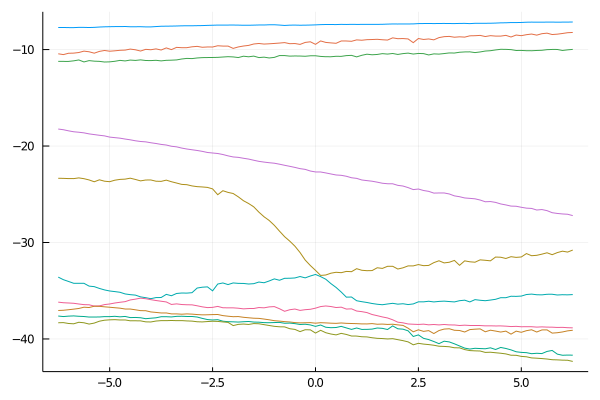

In [12]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs, legend=false, fmt = :png)

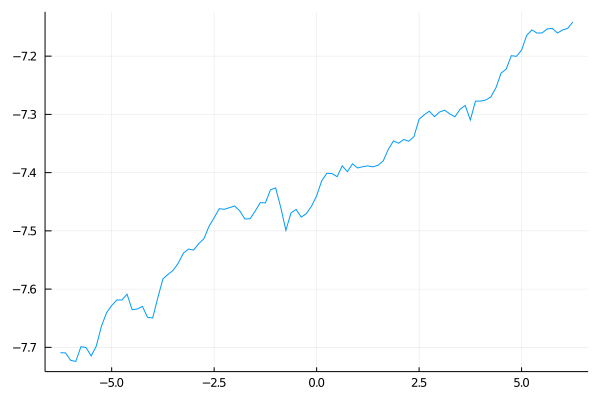

In [14]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,1], legend=false, fmt = :png)

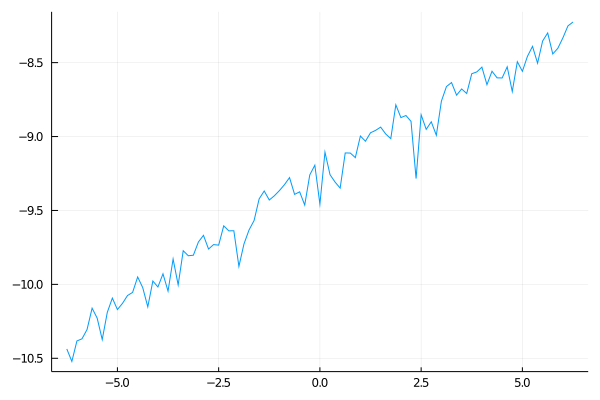

In [15]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,2], legend=false, fmt = :png)

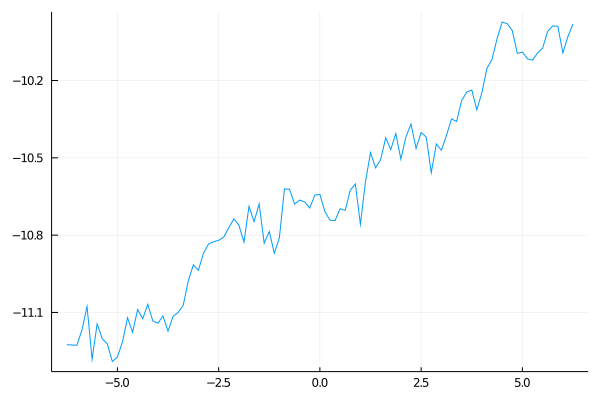

In [16]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,3], legend=false, fmt = :png)

In [17]:
[range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1)  evs]

101×11 Array{Float64,2}:
 -6.25   -7.70918  -10.4369   -11.2253   …  -37.0491  -37.6228  -38.3207
 -6.125  -7.70962  -10.5213   -11.2263      -37.0256  -37.6778  -38.3057
 -6.0    -7.72234  -10.3828   -11.2273      -36.9695  -37.6336  -38.3949
 -5.875  -7.72418  -10.3684   -11.1681      -36.9088  -37.6102  -38.4293
 -5.75   -7.69885  -10.3055   -11.0767      -36.8396  -37.6494  -38.2697
 -5.625  -7.70038  -10.1612   -11.2817   …  -36.7085  -37.674   -38.3219
 -5.5    -7.71476  -10.2283   -11.1445      -36.7416  -37.7287  -38.4562
 -5.375  -7.69782  -10.3734   -11.2015      -36.606   -37.7265  -38.3534
 -5.25   -7.66373  -10.1894   -11.2224      -36.618   -37.7214  -38.1591
 -5.125  -7.64065  -10.0928   -11.2901      -36.669   -37.6835  -38.0564
 -5.0    -7.62815  -10.1703   -11.2732   …  -36.7116  -37.6863  -38.0175
 -4.875  -7.61875  -10.1286   -11.2145      -36.7621  -37.6513  -37.9996
 -4.75   -7.61862  -10.0751   -11.1208      -36.8078  -37.7055  -38.0322
  ⋮                       

In [18]:
evs

101×10 Array{Float64,2}:
 -7.70918  -10.4369   -11.2253   -18.2375  …  -37.0491  -37.6228  -38.3207
 -7.70962  -10.5213   -11.2263   -18.3094     -37.0256  -37.6778  -38.3057
 -7.72234  -10.3828   -11.2273   -18.4243     -36.9695  -37.6336  -38.3949
 -7.72418  -10.3684   -11.1681   -18.5203     -36.9088  -37.6102  -38.4293
 -7.69885  -10.3055   -11.0767   -18.5699     -36.8396  -37.6494  -38.2697
 -7.70038  -10.1612   -11.2817   -18.6341  …  -36.7085  -37.674   -38.3219
 -7.71476  -10.2283   -11.1445   -18.7408     -36.7416  -37.7287  -38.4562
 -7.69782  -10.3734   -11.2015   -18.8132     -36.606   -37.7265  -38.3534
 -7.66373  -10.1894   -11.2224   -18.8853     -36.618   -37.7214  -38.1591
 -7.64065  -10.0928   -11.2901   -18.9477     -36.669   -37.6835  -38.0564
 -7.62815  -10.1703   -11.2732   -19.0739  …  -36.7116  -37.6863  -38.0175
 -7.61875  -10.1286   -11.2145   -19.1299     -36.7621  -37.6513  -37.9996
 -7.61862  -10.0751   -11.1208   -19.1846     -36.8078  -37.7055  -38.0322


In [19]:
using DelimitedFiles

In [20]:
writedlm("D:/ocean_wind_"*string(grid_resolution)*"_"*string(Integer(num_steps/2)*ϵ)*"_"*string(t_end-t_initial)*".csv", [range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1)  evs], ",")